In [28]:
import os 
import sys
sys.path.append("../galess")
import lens_stat as ls
import utils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [6]:
params_paper = {
   'axes.labelsize': 14,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [6, 4]
   }

params_keynote = {
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": '#222222',
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": 'white',
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": '#222222',
    "figure.edgecolor": 'lightgray',
    "savefig.facecolor":'#222222',
    "savefig.edgecolor": 'lightgray'
    }

plt.rcParams.update(params_paper)   

In [19]:
temp_M_array     = np.linspace(-13 , -25 , 25)
temp_sigma_array = np.linspace(100 , 400 , 31)
temp_zl_array    = np.linspace(0.  , 2.5 , 26)
temp_zs_array    = np.linspace(0.  , 10  , 21)
temp_min_SNR     = 20
temp_arc_mu_thr  = 3

temp_title    = 'EUCLID Wide VIS'
temp_limit    = 26.2
temp_cut      = 25
temp_area     = 15000
temp_seeing   = 0.17
temp_exp_time_sec = 1610
temp_pixel_arcsec = 0.1
temp_zero_point_m = 25.5
temp_sky_bckgnd_m = 22.2
temp_photo_band  = 'sdss_i0'

''''''
temp_noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                            temp_sigma_array, temp_zl_array, temp_zs_array, temp_M_array, temp_limit, temp_area, 
                                                            temp_seeing, temp_min_SNR, temp_exp_time_sec, temp_sky_bckgnd_m, temp_zero_point_m, temp_pixel_arcsec, 
                                                            photo_band = temp_photo_band, mag_cut=temp_cut, arc_mu_threshold = temp_arc_mu_thr, 
                                                            LENS_LIGHT_FLAG = False, SIE_FLAG = True)


temp_LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                            temp_sigma_array, temp_zl_array, temp_zs_array, temp_M_array, temp_limit, temp_area, 
                                                            temp_seeing, temp_min_SNR, temp_exp_time_sec, temp_sky_bckgnd_m, temp_zero_point_m, temp_pixel_arcsec, 
                                                            photo_band = temp_photo_band, mag_cut=temp_cut, arc_mu_threshold = temp_arc_mu_thr, 
                                                            LENS_LIGHT_FLAG = True, SIE_FLAG = False)

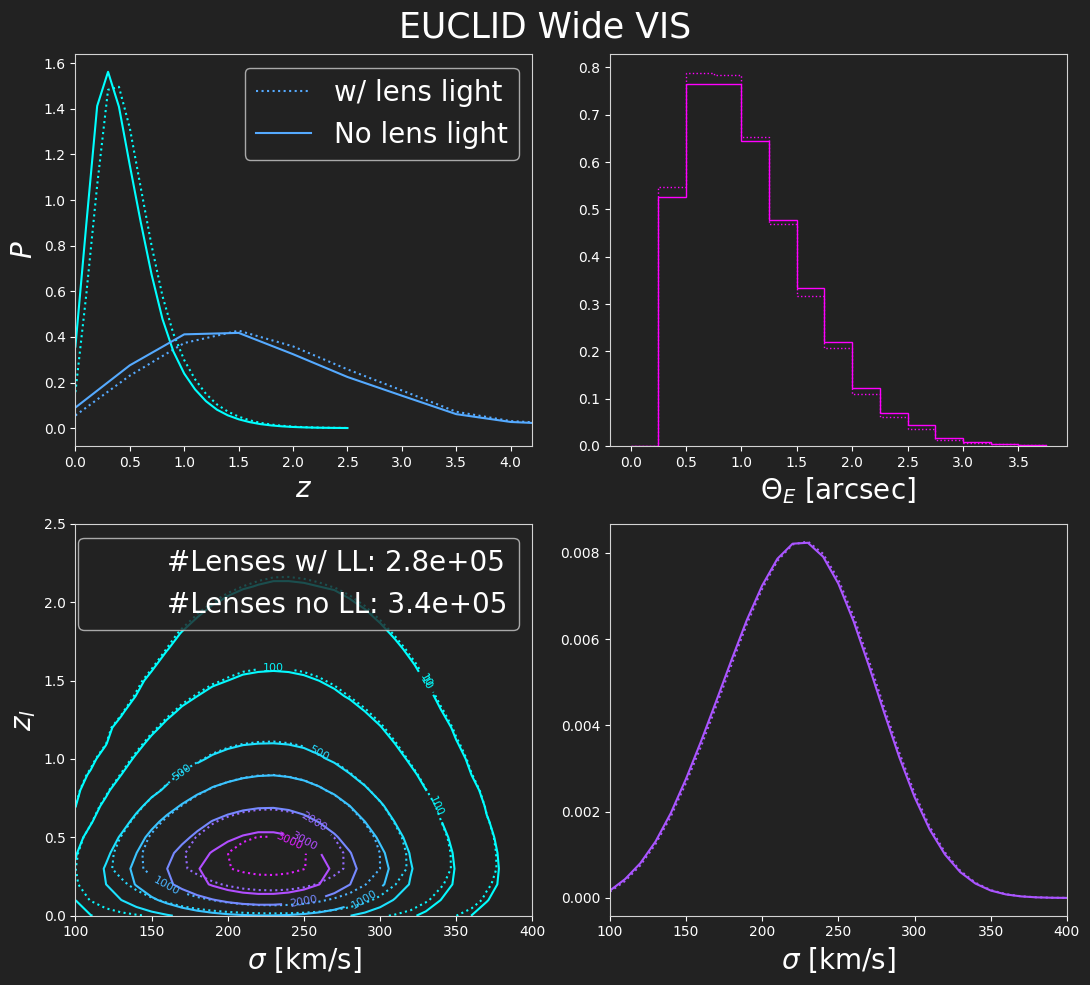

In [42]:
if(1): 
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update(params_keynote)
    line_c = 'w'
    cmap_c = cm.cool
    _col_  = iter(cmap_c(np.linspace(0, 1, 4)))
    col_A  = next(_col_)
    col_B  = next(_col_)
    col_C  = next(_col_)
    col_D  = next(_col_)
    fn_prefix = 'KEY_'
else:
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update(params_paper)   
    line_c = 'k'
    cmap_c = cm.inferno
    col_A  = 'r'
    col_B  = 'k'
    col_C  = 'k'
    col_D  = 'k'
    fn_prefix = ''

Ngal_zl_sigma_temp_noLL, Ngal_zs_sigma_temp_noLL, Ngal_zs_zl_temp_noLL, P_zs_temp_noLL, P_zl_temp_noLL, P_sg_temp_noLL = ls.get_N_and_P_projections(temp_noLL, temp_sigma_array, temp_zl_array, temp_zs_array, 1)
Ngal_zl_sigma_temp_LL, Ngal_zs_sigma_temp_LL, Ngal_zs_zl_temp_LL, P_zs_temp_LL, P_zl_temp_LL, P_sg_temp_LL = ls.get_N_and_P_projections(temp_LL, temp_sigma_array, temp_zl_array, temp_zs_array, 1)

_nbins_zl = np.arange(0.0, 1.6, 0.2 )
_nbins_zs = np.arange(0.0, 5  , 0.5 )
_nbins_sg = np.arange(100, 400, 25  )
_nbins_Re = np.arange(0  , 4  , 0.25)
    
fig, ax = plt.subplots(2, 2, figsize=(11, 10), sharex=False, sharey=False)
plt.subplots_adjust(wspace=.15, hspace=.2)
fig.suptitle(temp_title, fontsize=25)
ax[0,0].plot(temp_zl_array, P_zl_temp_LL, c=col_A, ls=':')
ax[0,0].plot(temp_zs_array, P_zs_temp_LL, c=col_B, ls=':' , label='w/ lens light')
ax[0,0].plot(temp_zl_array, P_zl_temp_noLL, c=col_A, ls='-')
ax[0,0].plot(temp_zs_array, P_zs_temp_noLL, c=col_B, ls='-', label='No lens light')
ax[0,0].set_ylabel(r'$P$', fontsize=20)
ax[0,0].set_xlabel(r'$z$', fontsize=20)
ax[1,1].plot(temp_sigma_array, P_sg_temp_LL, c=col_C, ls = ':')
ax[1,1].plot(temp_sigma_array, P_sg_temp_noLL, c=col_C, ls = '-')
ax[1,1].set_xlabel(r'$\sigma$ [km/s]', fontsize=20)
ax[0,1].hist(np.ravel(Theta_E_LL), weights=np.ravel(temp_LL), bins=_nbins_Re, range=(0, 3), density=True, histtype='step', color=col_D, ls = ':')
ax[0,1].hist(np.ravel(Theta_E_noLL), weights=np.ravel(temp_noLL), bins=_nbins_Re, range=(0, 3), density=True, histtype='step', color=col_D, ls = '-')
ax[0,1].set_xlabel(r'$\Theta_E$ [arcsec]', fontsize=20)

_sigma, _zl = np.meshgrid(temp_sigma_array, temp_zl_array)
ax[0,0].legend(fontsize=20)

levels   = np.asarray([0.01, 0.1, 0.5, 1, 2, 3, 5])*(np.power(10,np.ceil(np.log10(np.max(Ngal_zl_sigma_temp_LL))-1)))
contours = ax[1,0].contour(_sigma, _zl,Ngal_zl_sigma_temp_LL.T, levels, cmap=cmap_c, norm=colors.Normalize(vmin=np.min(Ngal_zl_sigma_temp_LL), vmax=np.max(Ngal_zl_sigma_temp_LL)), linestyles=':')
ax[1,0].scatter(200,1.0, label='', alpha=0)
ax[1,0].clabel(contours, inline=True, fontsize=8)
ax[1,0].set_xlabel(r'$\sigma$ [km/s]', fontsize=20)
ax[1,0].set_ylabel(r'$z_l$', fontsize=20)

levels   = np.asarray([0.01, 0.1, 0.5, 1, 2, 3, 5])*(np.power(10,np.ceil(np.log10(np.max(Ngal_zl_sigma_temp_noLL))-1)))
contours = ax[1,0].contour(_sigma, _zl,Ngal_zl_sigma_temp_noLL.T, levels, cmap=cmap_c, norm=colors.Normalize(vmin=np.min(Ngal_zl_sigma_temp_noLL), vmax=np.max(Ngal_zl_sigma_temp_noLL)), linestyles='-')
ax[1,0].scatter(200,1.0, label='', alpha=0)
ax[1,0].clabel(contours, inline=True, fontsize=8)
if(np.sum(temp_noLL))>10_000:
    ax[1,0].legend([f'#Lenses w/ LL: {np.sum(temp_LL):.1e}', f'#Lenses no LL: {np.sum(temp_noLL):.1e}'], fontsize=20)
else:
    ax[1,0].legend([f'#Lenses w/ LL: {np.sum(temp_LL):.0f}', f'#Lenses no LL: {np.sum(temp_noLL):.0f}'], fontsize=20)
   
ax[1,0].set_xlabel(r'$\sigma$ [km/s]', fontsize=20)
ax[1,0].set_ylabel(r'$z_l$', fontsize=20)

ax[0,0].set_xlim((0,4.2))
ax[1,1].set_xlim((100,400))
ax[1,0].set_xlim((100,400))
ax[1,0].set_ylim((0,2.5))
if(0):
    ax[0,0].set_yscale('log')
    ax[0,2].set_yscale('log')
    ax[0,0].set_ylim((1e-3,2))
    ax[0,2].set_ylim((1e-3,2))
    
plt.tight_layout()

folderpath = 'img/'+utils.remove_spaces_from_string(temp_title)
if not os.path.exists(folderpath): os.makedirs(folderpath)
plt.savefig(folderpath+'/'+fn_prefix+'corner_plts.jpg', dpi=200)
plt.show()

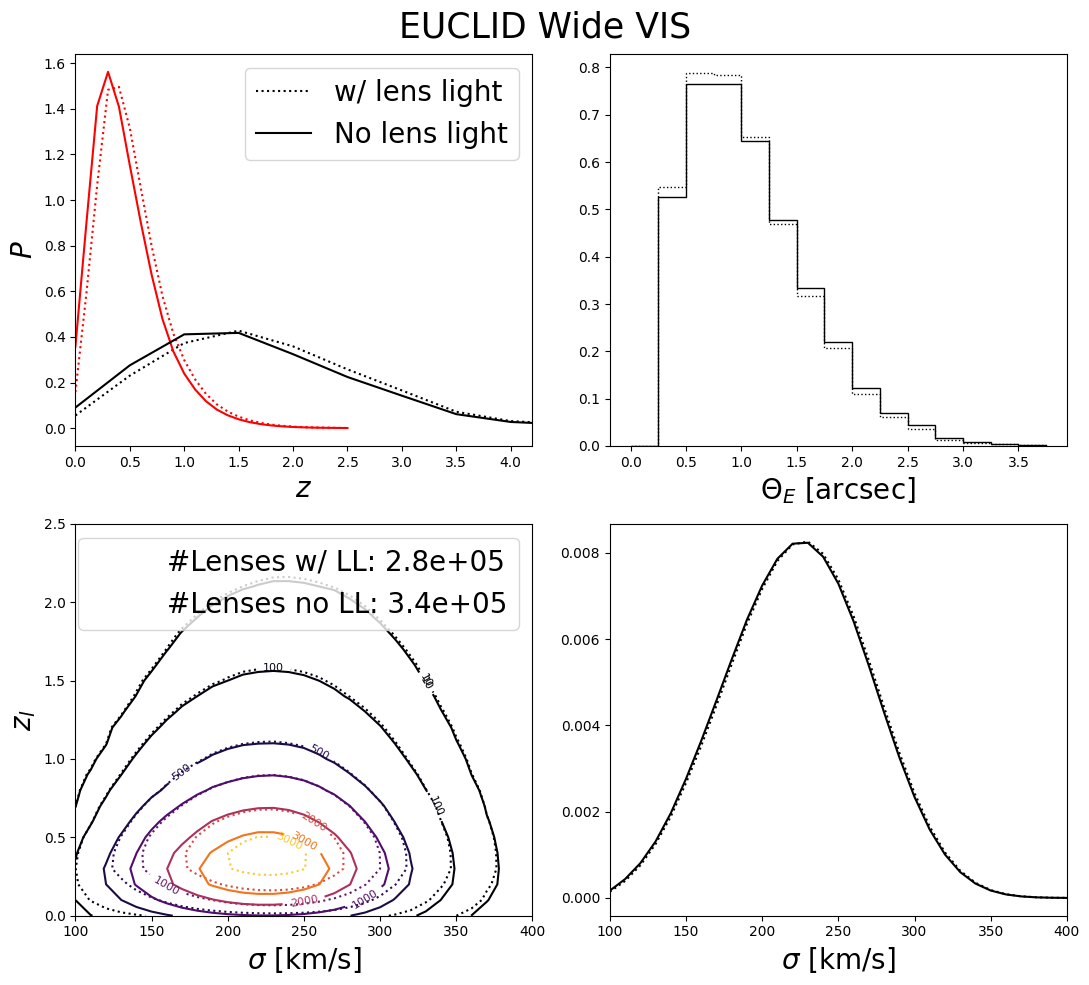

In [41]:
if(0): 
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update(params_keynote)
    line_c = 'w'
    cmap_c = cm.cool
    _col_  = iter(cmap_c(np.linspace(0, 1, 4)))
    col_A  = next(_col_)
    col_B  = next(_col_)
    col_C  = next(_col_)
    col_D  = next(_col_)
    fn_prefix = 'KEY_'
else:
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update(params_paper)   
    line_c = 'k'
    cmap_c = cm.inferno
    col_A  = 'r'
    col_B  = 'k'
    col_C  = 'k'
    col_D  = 'k'
    fn_prefix = ''

Ngal_zl_sigma_temp_noLL, Ngal_zs_sigma_temp_noLL, Ngal_zs_zl_temp_noLL, P_zs_temp_noLL, P_zl_temp_noLL, P_sg_temp_noLL = ls.get_N_and_P_projections(temp_noLL, temp_sigma_array, temp_zl_array, temp_zs_array, 1)
Ngal_zl_sigma_temp_LL, Ngal_zs_sigma_temp_LL, Ngal_zs_zl_temp_LL, P_zs_temp_LL, P_zl_temp_LL, P_sg_temp_LL = ls.get_N_and_P_projections(temp_LL, temp_sigma_array, temp_zl_array, temp_zs_array, 1)

_nbins_zl = np.arange(0.0, 1.6, 0.2 )
_nbins_zs = np.arange(0.0, 5  , 0.5 )
_nbins_sg = np.arange(100, 400, 25  )
_nbins_Re = np.arange(0  , 4  , 0.25)
    
fig, ax = plt.subplots(2, 2, figsize=(11, 10), sharex=False, sharey=False)
plt.subplots_adjust(wspace=.1, hspace=.05)
fig.suptitle(temp_title, fontsize=25)
ax[0,0].plot(temp_zl_array, P_zl_temp_LL, c=col_A, ls=':')
ax[0,0].plot(temp_zs_array, P_zs_temp_LL, c=col_B, ls=':' , label='w/ lens light')
ax[0,0].plot(temp_zl_array, P_zl_temp_noLL, c=col_A, ls='-')
ax[0,0].plot(temp_zs_array, P_zs_temp_noLL, c=col_B, ls='-', label='No lens light')
ax[0,0].set_ylabel(r'$P$', fontsize=20)
ax[0,0].set_xlabel(r'$z$', fontsize=20)
ax[1,1].plot(temp_sigma_array, P_sg_temp_LL, c=col_C, ls = ':')
ax[1,1].plot(temp_sigma_array, P_sg_temp_noLL, c=col_C, ls = '-')
ax[1,1].set_xlabel(r'$\sigma$ [km/s]', fontsize=20)
ax[0,1].hist(np.ravel(Theta_E_LL), weights=np.ravel(temp_LL), bins=_nbins_Re, range=(0, 3), density=True, histtype='step', color=col_D, ls = ':')
ax[0,1].hist(np.ravel(Theta_E_noLL), weights=np.ravel(temp_noLL), bins=_nbins_Re, range=(0, 3), density=True, histtype='step', color=col_D, ls = '-')
ax[0,1].set_xlabel(r'$\Theta_E$ [arcsec]', fontsize=20)

_sigma, _zl = np.meshgrid(temp_sigma_array, temp_zl_array)
ax[0,0].legend(fontsize=20)

levels   = np.asarray([0.01, 0.1, 0.5, 1, 2, 3, 5])*(np.power(10,np.ceil(np.log10(np.max(Ngal_zl_sigma_temp_LL))-1)))
contours = ax[1,0].contour(_sigma, _zl,Ngal_zl_sigma_temp_LL.T, levels, cmap=cmap_c, norm=colors.Normalize(vmin=np.min(Ngal_zl_sigma_temp_LL), vmax=np.max(Ngal_zl_sigma_temp_LL)), linestyles=':')
ax[1,0].scatter(200,1.0, label='', alpha=0)
ax[1,0].clabel(contours, inline=True, fontsize=8)
ax[1,0].set_xlabel(r'$\sigma$ [km/s]', fontsize=20)
ax[1,0].set_ylabel(r'$z_l$', fontsize=20)

levels   = np.asarray([0.01, 0.1, 0.5, 1, 2, 3, 5])*(np.power(10,np.ceil(np.log10(np.max(Ngal_zl_sigma_temp_noLL))-1)))
contours = ax[1,0].contour(_sigma, _zl,Ngal_zl_sigma_temp_noLL.T, levels, cmap=cmap_c, norm=colors.Normalize(vmin=np.min(Ngal_zl_sigma_temp_noLL), vmax=np.max(Ngal_zl_sigma_temp_noLL)), linestyles='-')
ax[1,0].scatter(200,1.0, label='', alpha=0)
ax[1,0].clabel(contours, inline=True, fontsize=8)
if(np.sum(temp_noLL))>10_000:
    ax[1,0].legend([f'#Lenses w/ LL: {np.sum(temp_LL):.1e}', f'#Lenses no LL: {np.sum(temp_noLL):.1e}'], fontsize=20)
else:
    ax[1,0].legend([f'#Lenses w/ LL: {np.sum(temp_LL):.0f}', f'#Lenses no LL: {np.sum(temp_noLL):.0f}'], fontsize=20)
   
ax[1,0].set_xlabel(r'$\sigma$ [km/s]', fontsize=20)
ax[1,0].set_ylabel(r'$z_l$', fontsize=20)

ax[0,0].set_xlim((0,4.2))
ax[1,1].set_xlim((100,400))
ax[1,0].set_xlim((100,400))
ax[1,0].set_ylim((0,2.5))
if(0):
    ax[0,0].set_yscale('log')
    ax[0,2].set_yscale('log')
    ax[0,0].set_ylim((1e-3,2))
    ax[0,2].set_ylim((1e-3,2))
    
plt.tight_layout()

folderpath = 'img/'+utils.remove_spaces_from_string(temp_title)
if not os.path.exists(folderpath): os.makedirs(folderpath)
plt.savefig(folderpath+'/'+fn_prefix+'corner_plts.jpg', dpi=200)
plt.show()